# Model Training

In [1]:
import MIMENetEnsemble
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json

In [2]:
#set path to simulation data
simulation_path = "../data/simulation_data/experimental_conditions_2"

In [3]:
#set training parameters
training_path = "../data/simulation_data/experimental_conditions_2/second_round/"
epochs = 100
learning_rate = 0.00001
batch_size = 2**16
lambda_l2 = 0.00001
hidden_size_factor = 2
bottleneck = 1/2

In [4]:
model, history = MIMENetEnsemble.train(
    training_path=training_path+'parsed_reads.txt',
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    lambda_l2=lambda_l2,
    hidden_size_factor=hidden_size_factor,
    bottleneck=bottleneck,
    kd_path="../data/simulation_data/experimental_conditions_2/secondFromProt1/prot1/single_kds.txt",
    model_path=None
)

Device: cuda:0
Number of training examples: 12968764


100%|██████████| 100/100 [21:31:55<00:00, 775.15s/it]  


In [5]:
#save model
torch.save(model.state_dict(), './ensembleExpCond2.pth')

In [6]:
#save training history as json
with open('./history_exp_ens2.json', 'w') as f:
    json.dump(history, f)

In [4]:
#load saved model, training history, and prediction history
input_size = len(open(training_path+'parsed_reads.txt').readline().split('_')[0])
model = MIMENetEnsemble.MIMENetEnsemble(input_size, hidden_size_factor, bottleneck, 1)
model.load_state_dict(torch.load('./ensembleExpCond2.pth'))
#puto model to gpu
model.to('cuda:0')
#load history
with open('./history_exp_ens2.json', 'r') as f:
    history = json.load(f)

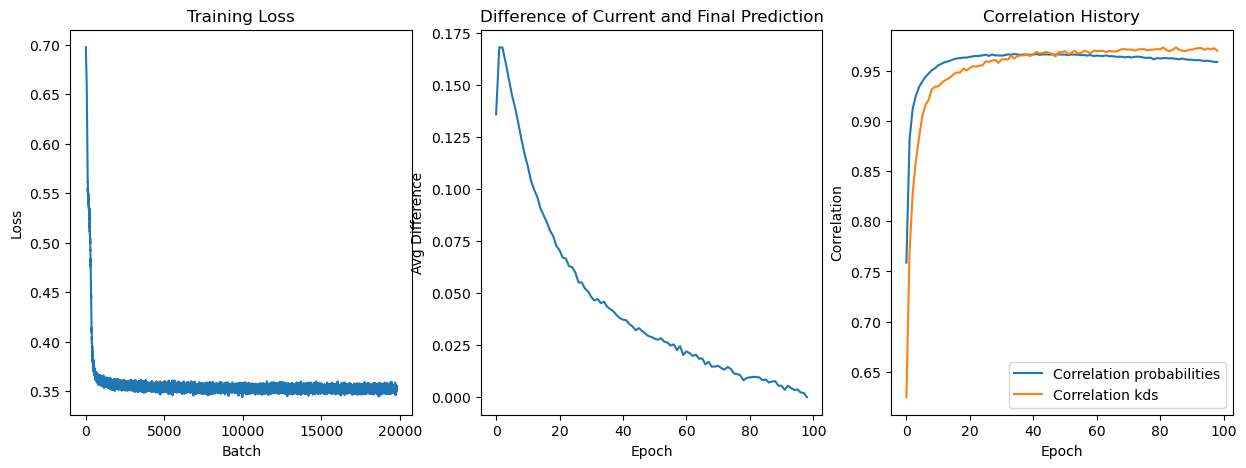

In [5]:
# set up 3 side by side plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

#plot training history
axs[0].plot(history['training'])
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')

#plot difference of current and final prediction

#initialize difference array
predictions = np.array(history['prediction'][1:])
difference = np.zeros((predictions.shape[0], predictions.shape[1]))
#calculate difference
for i in range(predictions.shape[0]):
    difference[i] = np.abs(predictions[i] - predictions[-1])
#average over columns
difference = np.mean(difference, axis=1)
#plot difference
axs[1].plot(difference)
axs[1].set_title('Difference of Current and Final Prediction')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Avg Difference')

#plot correlation history rows as lines
axs[2].plot(history['correlation_probs'][1:], label='Correlation probabilities')
axs[2].plot(history['correlation_kds'][1:], label='Correlation kds')
axs[2].legend()
axs[2].set_title("Correlation History")
axs[2].set_ylabel("Correlation")
axs[2].set_xlabel("Epoch")
plt.show()

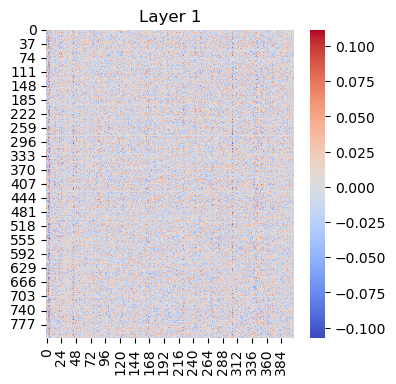

max weight value:  0.11150476
min weight value:  -0.10704135
number of pruned weights:  0
number of non zero weights:  329672
max bias value:  0.05644426
min bias value:  -0.04866683
number of pruned biases:  0
number of non zero biases:  812


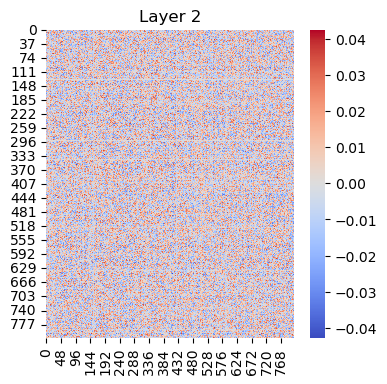

max weight value:  0.042471614
min weight value:  -0.042673044
number of pruned weights:  0
number of non zero weights:  659344
max bias value:  0.040734872
min bias value:  -0.034402557
number of pruned biases:  0
number of non zero biases:  812


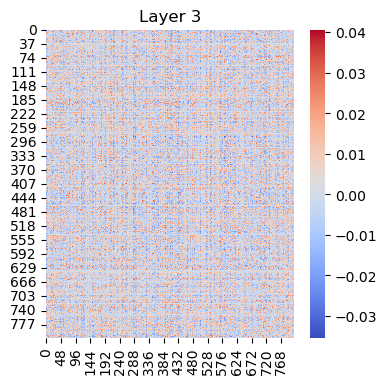

max weight value:  0.040652264
min weight value:  -0.035364714
number of pruned weights:  0
number of non zero weights:  659344
max bias value:  0.049513146
min bias value:  -0.03310842
number of pruned biases:  0
number of non zero biases:  812


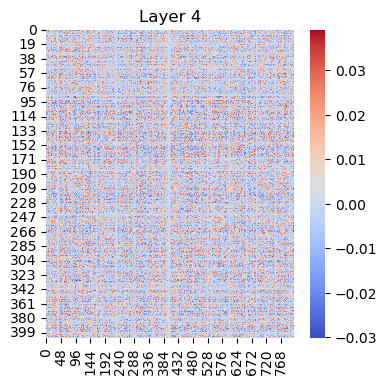

max weight value:  0.03909146
min weight value:  -0.030116012
number of pruned weights:  0
number of non zero weights:  329672
max bias value:  0.04305079
min bias value:  -0.038560133
number of pruned biases:  0
number of non zero biases:  406


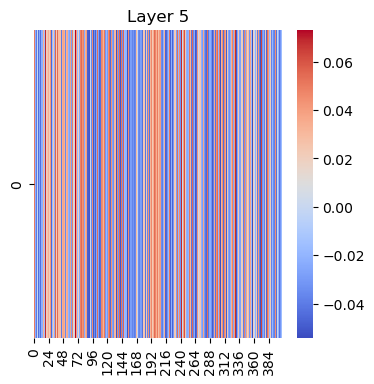

max weight value:  0.073265694
min weight value:  -0.054115806
number of pruned weights:  0
number of non zero weights:  406
max bias value:  0.024875956
min bias value:  0.024875956
number of pruned biases:  0
number of non zero biases:  1


In [6]:
for name, param in model.named_parameters():
    #if weight is not a bias
    if 'bias' not in name:
        #reshape weights to 2d array
        weight = param.data.cpu().numpy().reshape(param.data.cpu().numpy().shape[0], param.data.cpu().numpy().shape[1])
        #plot heatmap of weights
        plt.figure(figsize=(4,4))
        sns.heatmap(weight, cmap='coolwarm')
        # get layer number from name
        layer = [int(s) for s in name if s.isdigit()]
        plt.title(f'Layer {layer[0]}')
        plt.show()

        print('max weight value: ', np.max(weight))
        print('min weight value: ', np.min(weight))
        print('number of pruned weights: ', np.sum(weight == 0))
        print('number of non zero weights: ', np.sum(weight != 0))

    else:
        bias = param.data.cpu().numpy()
 
        print('max bias value: ', np.max(bias))
        print('min bias value: ', np.min(bias))
        print('number of pruned biases: ', np.sum(bias == 0))
        print('number of non zero biases: ', np.sum(bias != 0))

# Single Probabilities

In [7]:
# read in kd values
single_kd_sim = np.loadtxt(simulation_path+'/secondFromProt1/prot1/single_kds.txt')

#insert 1 at position 0 and then every 3rd position
single_kd_sim = np.insert(single_kd_sim, 0, 1)
single_kd_sim = np.insert(single_kd_sim, np.arange(4, len(single_kd_sim), 3), 1)
single_kd_sim[0:10]

array([1.      , 1.      , 1.      , 1.      , 1.      , 1.      ,
       0.400124, 0.270107, 1.      , 1.      ])

In [8]:
input_size = len(open(training_path+'parsed_reads.txt').readline().split('_')[0])
single_prob_pred = MIMENetEnsemble.inferSingleProbabilities(model, input_size, 1000)

In [9]:
single_prob_pred = np.array(single_prob_pred)
single_prob_pred_means = np.mean(single_prob_pred, axis=1)
single_prob_pred_conf = np.zeros((single_prob_pred_means.shape[0], 2))
for i in range(single_prob_pred_means.shape[0]):
    single_prob_pred_conf[i] = np.quantile(single_prob_pred[i], [0.025, 0.975])

print(single_prob_pred_means[0:10])
print(single_prob_pred_conf[0:10])

[0.38408026 0.3678564  0.3729308  0.39398566 0.34653978 0.33490655
 0.57160484 0.65709807 0.35406238 0.3926006 ]
[[0.34564478 0.42456191]
 [0.33323095 0.40559336]
 [0.34030119 0.40814643]
 [0.35767684 0.42884237]
 [0.30923182 0.38162033]
 [0.3005322  0.37252373]
 [0.54033087 0.60237534]
 [0.62583683 0.68736885]
 [0.32034898 0.38919299]
 [0.35885788 0.42799282]]


Text(0.8, 0.1, 'r = 0.96')

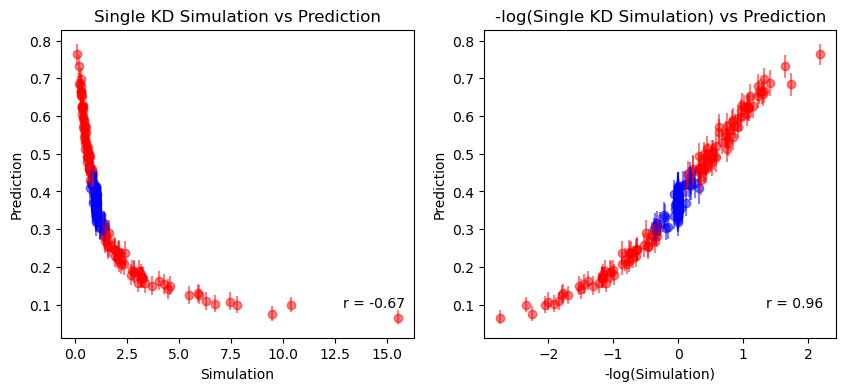

In [10]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# every 4th value is wildtype, get indices of wildtype values
wt_indices = np.arange(0, len(single_kd_sim), 4)

# go through all indices
for i in range(len(single_kd_sim)):
    # if index is wildtype
    if i in wt_indices:
        continue
    
    # get index of wildtype value
    wt_index = i - (i % 4)
    # get interval of wildtype value
    wt_interval = single_prob_pred_conf[wt_index]
    # get interval of current value
    interval = single_prob_pred_conf[i]
    # if intervals do not overlap plot in red
    if wt_interval[0] > interval[1] or wt_interval[1] < interval[0]:
        ax1.scatter(single_kd_sim[i], single_prob_pred_means[i], color='red', alpha=0.5)
        ax1.vlines(single_kd_sim[i], single_prob_pred_conf[i, 0], single_prob_pred_conf[i, 1], color='red', alpha=0.5)
    else:
        ax1.scatter(single_kd_sim[i], single_prob_pred_means[i], color='blue', alpha=0.5)
        ax1.vlines(single_kd_sim[i], single_prob_pred_conf[i, 0], single_prob_pred_conf[i, 1], color='blue', alpha=0.5)

ax1.set_title('Single KD Simulation vs Prediction')
ax1.set_xlabel('Simulation')
ax1.set_ylabel('Prediction')
# add correlation coefficient to plot
ax1.text(0.8, 0.1, f'r = {np.corrcoef(single_kd_sim, single_prob_pred_means)[0, 1]:.2f}', transform=ax1.transAxes)


# every 4th value is wildtype, get indices of wildtype values
wt_indices = np.arange(0, len(single_kd_sim), 4)
# go through all indices
for i in range(len(single_kd_sim)):
    # if index is wildtype
    if i in wt_indices:
        continue
    
    # get index of wildtype value
    wt_index = i - (i % 4)
    # get interval of wildtype value
    wt_interval = single_prob_pred_conf[wt_index]
    # get value of wildtype
    wt_value = single_prob_pred_means[wt_index]
    # get interval of current value
    interval = single_prob_pred_conf[i]
    # get value of current value
    value = single_prob_pred_means[i]
    # if intervals do not overlap plot in red
    if wt_interval[0] > interval[1] or wt_interval[1] < interval[0]:
        ax2.scatter(-np.log(single_kd_sim[i]), single_prob_pred_means[i], color='red', alpha=0.5)
        ax2.vlines(-np.log(single_kd_sim[i]), single_prob_pred_conf[i, 0], single_prob_pred_conf[i, 1], color='red', alpha=0.5)
    else:
        ax2.scatter(-np.log(single_kd_sim[i]), single_prob_pred_means[i], color='blue', alpha=0.5)
        ax2.vlines(-np.log(single_kd_sim[i]), single_prob_pred_conf[i, 0], single_prob_pred_conf[i, 1], color='blue', alpha=0.5)

ax2.set_title('-log(Single KD Simulation) vs Prediction')
ax2.set_xlabel('-log(Simulation)')
ax2.set_ylabel('Prediction')
# add correlation coefficient to plot
ax2.text(0.8, 0.1, f'r = {np.corrcoef(-np.log(single_kd_sim), single_prob_pred_means)[0, 1]:.2f}', transform=ax2.transAxes)

In [11]:
# constructing confusion matrix for probabilities

prob_fp = 0
prob_fn = 0
prob_tp = 0
prob_tn = 0
# iterate through all values
for i in range(len(single_kd_sim)):
    if i in wt_indices:
        continue
    # get index of wildtype value
    wt_index = i - (i % 4)
    wt_interval = single_prob_pred_conf[wt_index]
    interval = single_prob_pred_conf[i]
    # if intervals do not overlap > positive
    if wt_interval[0] > interval[1] or wt_interval[1] < interval[0]:
        # if simulation is negative
        if single_kd_sim[i] == 1:
            prob_fp += 1
        # if simulation is positive
        else:
            prob_tp += 1
    # if intervals overlap > negative
    else:
        # if simulation is negative
        if single_kd_sim[i] == 1:
            prob_tn += 1
        # if simulation is positive
        else:
            prob_fn += 1

# print confusion matrix
print('Confusion Matrix - Probabilities:'+ '\n')
print(f'{"":>10}{"Simulation+":>10}{"Simulation-"}')
print(f'{"Prediction+":>10}{prob_tp:>10}{prob_fp:>10}')
print(f'{"Prediction-":>10}{prob_fn:>10}{prob_tn:>10}')

# print accuracy
print(f'Accuracy: {(prob_tp + prob_tn) / (prob_tp + prob_fp + prob_fn + prob_tn):.2f}' + '\n')

Confusion Matrix - Probabilities:

          Simulation+Simulation-
Prediction+       118         0
Prediction-        28       154
Accuracy: 0.91



# Single Kds

In [12]:
# read in kd values
single_kd_sim = np.loadtxt(simulation_path+'/secondFromProt1/prot1/single_kds.txt')

In [13]:
#predict kds
single_kd_pred = MIMENetEnsemble.inferSingleKds(model, input_size, 1000)

100%|██████████| 100/100 [04:39<00:00,  2.79s/it]


In [14]:
single_kd_pred = np.array(single_kd_pred)
single_kd_pred_means = np.mean(single_kd_pred, axis=1)
single_kd_pred_conf = np.zeros((single_kd_pred_means.shape[0], 2))
for i in range(single_kd_pred_means.shape[0]):
    single_kd_pred_conf[i] = np.quantile(single_kd_pred[i], [0.025, 0.975])

print(single_kd_pred_means[0:10])
print(single_kd_pred_means.shape)
print(single_kd_pred_conf[0:10])
print(single_kd_pred_conf.shape)

[1.08141938 1.05299355 0.97170343 1.05570222 0.3985389  0.27699721
 0.85241516 0.89304099 2.03045513 0.49781547]
(300,)
[[0.86244515 1.32289235]
 [0.84096519 1.30618389]
 [0.77506887 1.21589924]
 [0.83616797 1.3088713 ]
 [0.31929914 0.48702457]
 [0.22506514 0.34033685]
 [0.68202631 1.06927377]
 [0.7057169  1.10027745]
 [1.5949551  2.56309411]
 [0.39607625 0.61999921]]
(300, 2)


Text(0.6, 0.2, 'y = 0.92x + -0.04')

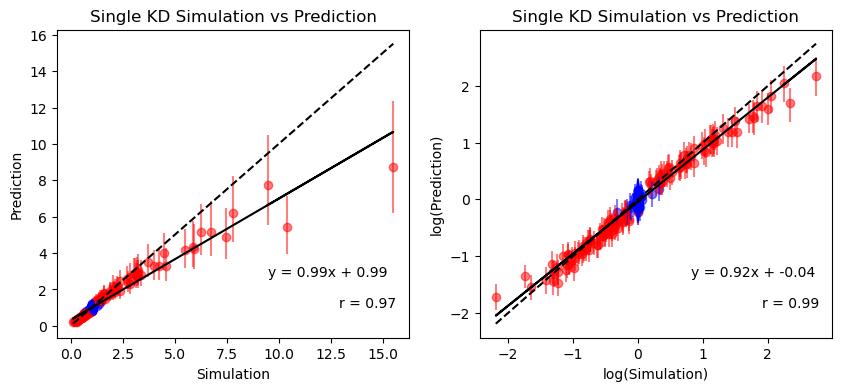

In [15]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# iterate through all values
for i in range(len(single_kd_sim)):
    # get interval of current value
    interval = single_kd_pred_conf[i]
    # get value of current value
    value = single_kd_pred_means[i]
    # if interval does not contain 1, plot in red
    if interval[0] > 1 or interval[1] < 1:
        # scatter plot value
        ax1.scatter(single_kd_sim[i], single_kd_pred_means[i], color='red', alpha=0.5)
        # plot interval
        ax1.vlines(single_kd_sim[i], single_kd_pred_conf[i, 0], single_kd_pred_conf[i, 1], color='red', alpha=0.5)
    else:
        # scatter plot value
        ax1.scatter(single_kd_sim[i], single_kd_pred_means[i], color='blue', alpha=0.5)
        # plot interval
        ax1.vlines(single_kd_sim[i], single_kd_pred_conf[i, 0], single_kd_pred_conf[i, 1], color='blue', alpha=0.5)
ax1.set_title('Single KD Simulation vs Prediction')
ax1.set_xlabel('Simulation')
ax1.set_ylabel('Prediction')
# add correlation coefficient to plot
ax1.text(0.8, 0.1, f'r = {np.corrcoef(single_kd_sim, single_kd_pred_means)[0, 1]:.2f}', transform=ax1.transAxes)
# plot 1:1 line as dashed
ax1.plot([min(single_kd_sim), max(single_kd_sim)], [min(single_kd_sim), max(single_kd_sim)], color='black', linestyle='dashed')
# plot line of best fit
ax1.plot(single_kd_sim, np.poly1d(np.polyfit(single_kd_sim, single_kd_pred_means, 1))(single_kd_sim), color='black')
# add equation of line of best fit rounded to 2 decimal places
ax1.text(0.6, 0.2, f'y = {np.poly1d(np.polyfit(single_kd_sim, single_kd_pred_means, 1))(single_kd_sim)[0]:.2f}x + {np.poly1d(np.polyfit(single_kd_sim, single_kd_pred_means, 1))(single_kd_sim)[1]:.2f}', transform=ax1.transAxes)

# everything with log transformed kd
# iterate through all values
for i in range(len(single_kd_sim)):
    # get interval of current value
    interval = single_kd_pred_conf[i]
    # get value of current value
    value = single_kd_pred_means[i]
    # if interval does not contain 1, plot in red
    if interval[0] > 1 or interval[1] < 1:
        # scatter plot value
        ax2.scatter(np.log(single_kd_sim[i]), np.log(single_kd_pred_means[i]), color='red', alpha=0.5)
        # plot interval
        ax2.vlines(np.log(single_kd_sim[i]), np.log(single_kd_pred_conf[i, 0]), np.log(single_kd_pred_conf[i, 1]), color='red', alpha=0.5)
    else:
        # scatter plot value
        ax2.scatter(np.log(single_kd_sim[i]), np.log(single_kd_pred_means[i]), color='blue', alpha=0.5)
        # plot interval
        ax2.vlines(np.log(single_kd_sim[i]), np.log(single_kd_pred_conf[i, 0]), np.log(single_kd_pred_conf[i, 1]), color='blue', alpha=0.5)

ax2.set_title('Single KD Simulation vs Prediction')
ax2.set_xlabel('log(Simulation)')
ax2.set_ylabel('log(Prediction)')
# add correlation coefficient to plot
ax2.text(0.8, 0.1, f'r = {np.corrcoef(np.log(single_kd_sim), np.log(single_kd_pred_means))[0, 1]:.2f}', transform=ax2.transAxes)
# add line of best fit
ax2.plot(np.log(single_kd_sim), np.poly1d(np.polyfit(np.log(single_kd_sim), np.log(single_kd_pred_means), 1))(np.log(single_kd_sim)), color='black')
# plot 1:1 line as dashed
ax2.plot([min(np.log(single_kd_sim)), max(np.log(single_kd_sim))], [min(np.log(single_kd_sim)), max(np.log(single_kd_sim))], color='black', linestyle='dashed')
# add equation of line of best fit rounded to 2 decimal places
ax2.text(0.6, 0.2, f'y = {np.poly1d(np.polyfit(np.log(single_kd_sim), np.log(single_kd_pred_means), 1))[1]:.2f}x + {np.poly1d(np.polyfit(np.log(single_kd_sim), np.log(single_kd_pred_means), 1))[0]:.2f}', transform=ax2.transAxes)


Text(0.6, 0.2, 'y = 1.56x + -0.52')

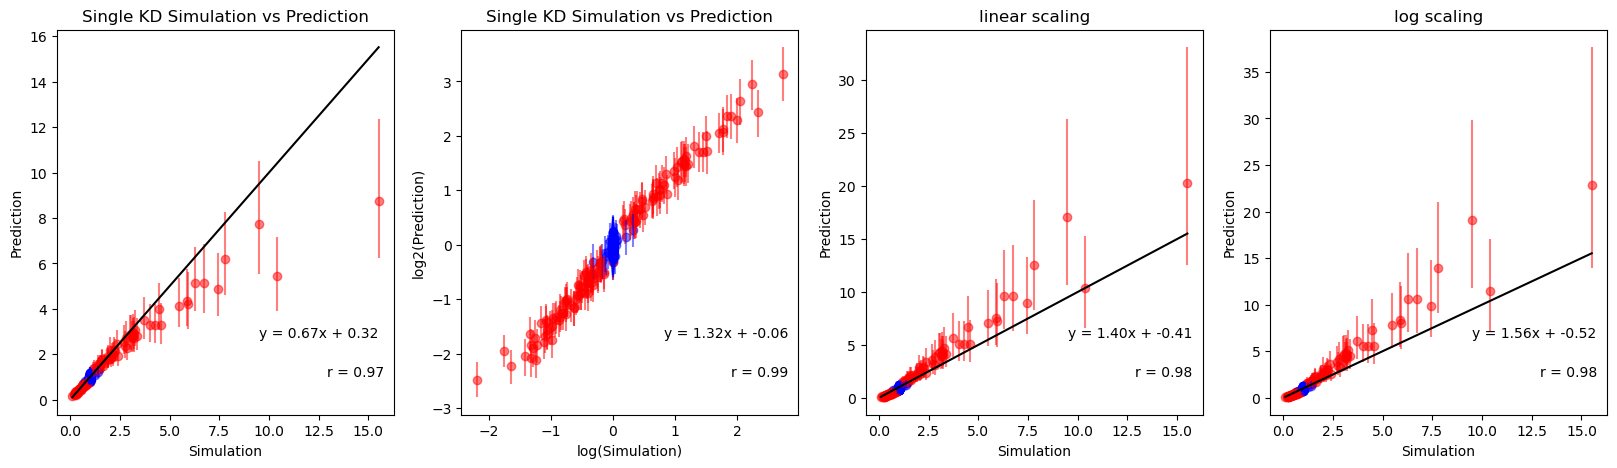

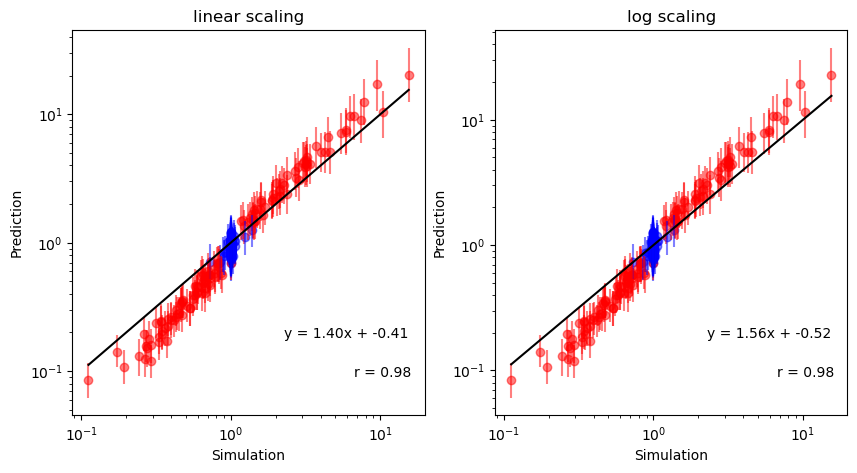

In [16]:
# set up 2 side by side plots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

# iterate through all values
for i in range(len(single_kd_sim)):
    # get interval of current value
    interval = single_kd_pred_conf[i]
    # get value of current value
    value = single_kd_pred_means[i]
    # if interval does not contain 1, plot in red
    if interval[0] > 1 or interval[1] < 1:
        # scatter plot value
        ax1.scatter(single_kd_sim[i], single_kd_pred_means[i], color='red', alpha=0.5)
        # plot interval
        ax1.vlines(single_kd_sim[i], single_kd_pred_conf[i, 0], single_kd_pred_conf[i, 1], color='red', alpha=0.5)
    else:
        # scatter plot value
        ax1.scatter(single_kd_sim[i], single_kd_pred_means[i], color='blue', alpha=0.5)
        # plot interval
        ax1.vlines(single_kd_sim[i], single_kd_pred_conf[i, 0], single_kd_pred_conf[i, 1], color='blue', alpha=0.5)
ax1.set_title('Single KD Simulation vs Prediction')
ax1.set_xlabel('Simulation')
ax1.set_ylabel('Prediction')
# add correlation coefficient to plot
ax1.text(0.8, 0.1, f'r = {np.corrcoef(single_kd_sim, single_kd_pred_means)[0, 1]:.2f}', transform=ax1.transAxes)
# addline from min sim to max sim
ax1.plot([min(single_kd_sim), max(single_kd_sim)], [min(single_kd_sim), max(single_kd_sim)], color='black')
# add equation of line of best fit rounded to 2 decimal places
ax1.text(0.6, 0.2, f'y = {np.poly1d(np.polyfit(single_kd_sim, single_kd_pred_means, 1))[1]:.2f}x + {np.poly1d(np.polyfit(single_kd_sim, single_kd_pred_means, 1))[0]:.2f}', transform=ax1.transAxes)

# everything with log transformed kd
# iterate through all values
for i in range(len(single_kd_sim)):
    # get interval of current value
    interval = single_kd_pred_conf[i]
    # get value of current value
    value = single_kd_pred_means[i]
    # if interval does not contain 1, plot in red
    if interval[0] > 1 or interval[1] < 1:
        # scatter plot value
        ax2.scatter(np.log(single_kd_sim[i]), np.log2(single_kd_pred_means[i]), color='red', alpha=0.5)
        # plot interval
        ax2.vlines(np.log(single_kd_sim[i]), np.log2(single_kd_pred_conf[i, 0]), np.log2(single_kd_pred_conf[i, 1]), color='red', alpha=0.5)
    else:
        # scatter plot value
        ax2.scatter(np.log(single_kd_sim[i]), np.log2(single_kd_pred_means[i]), color='blue', alpha=0.5)
        # plot interval
        ax2.vlines(np.log(single_kd_sim[i]), np.log2(single_kd_pred_conf[i, 0]), np.log2(single_kd_pred_conf[i, 1]), color='blue', alpha=0.5)

ax2.set_title('Single KD Simulation vs Prediction')
ax2.set_xlabel('log(Simulation)')
ax2.set_ylabel('log2(Prediction)')
# add correlation coefficient to plot
ax2.text(0.8, 0.1, f'r = {np.corrcoef(np.log(single_kd_sim), np.log2(single_kd_pred_means))[0, 1]:.2f}', transform=ax2.transAxes)
# add equation of line of best fit rounded to 2 decimal places
ax2.text(0.6, 0.2, f'y = {np.poly1d(np.polyfit(np.log(single_kd_sim), np.log2(single_kd_pred_means), 1))[1]:.2f}x + {np.poly1d(np.polyfit(np.log(single_kd_sim), np.log2(single_kd_pred_means), 1))[0]:.2f}', transform=ax2.transAxes)


# iterate through all values
for i in range(len(single_kd_sim)):
    # get interval of current value
    interval = single_kd_pred_conf[i]
    # get value of current value
    value = single_kd_pred_means[i]
    # if interval does not contain 1, plot in red
    if interval[0] > 1 or interval[1] < 1:
        # scatter plot value
        ax3.scatter(single_kd_sim[i], np.exp(1/.71*(-.03+np.log(single_kd_pred_means[i]))), color='red', alpha=0.5)
        # plot interval
        ax3.vlines(single_kd_sim[i], np.exp(1/.71*(-.03+np.log(single_kd_pred_conf[i, 0]))), np.exp(1/.71*(-.03+np.log(single_kd_pred_conf[i, 1]))), color='red', alpha=0.5)
    else:
        # scatter plot value
        ax3.scatter(single_kd_sim[i], np.exp(1/.71*(-.03+np.log(single_kd_pred_means[i]))), color='blue', alpha=0.5)
        # plot interval
        ax3.vlines(single_kd_sim[i], np.exp(1/.71*(-.03+np.log(single_kd_pred_conf[i, 0]))), np.exp(1/.71*(-.03+np.log(single_kd_pred_conf[i, 1]))), color='blue', alpha=0.5)
ax3.set_title('linear scaling')
ax3.set_xlabel('Simulation')
ax3.set_ylabel('Prediction')
# add correlation coefficient to plot
ax3.text(0.8, 0.1, f'r = {np.corrcoef(single_kd_sim, np.exp(1/.71*(-.03+np.log(single_kd_pred_means))))[0, 1]:.2f}', transform=ax3.transAxes)
# draw 1:1 line
ax3.plot([min(single_kd_sim), max(single_kd_sim)], [min(single_kd_sim), max(single_kd_sim)], color='black')
# add equation of line of best fit rounded to 2 decimal places
ax3.text(0.6, 0.2, f'y = {np.poly1d(np.polyfit(single_kd_sim, np.exp(1/.71*(-.03+np.log(single_kd_pred_means))), 1))[1]:.2f}x + {np.poly1d(np.polyfit(single_kd_sim, np.exp(1/.71*(-.03+np.log(single_kd_pred_means))), 1))[0]:.2f}', transform=ax3.transAxes)

# iterate through all values
for i in range(len(single_kd_sim)):
    # get interval of current value
    interval = single_kd_pred_conf[i]
    # get value of current value
    value = single_kd_pred_means[i]
    # if interval does not contain 1, plot in red
    if interval[0] > 1 or interval[1] < 1:
        # scatter plot value
        ax4.scatter(single_kd_sim[i], np.exp(np.log2(single_kd_pred_means[i])), color='red', alpha=0.5)
        # plot interval
        ax4.vlines(single_kd_sim[i], np.exp(np.log2(single_kd_pred_conf[i, 0])), np.exp(np.log2(single_kd_pred_conf[i, 1])), color='red', alpha=0.5)
    else:
        # scatter plot value
        ax4.scatter(single_kd_sim[i], np.exp(np.log2(single_kd_pred_means[i])), color='blue', alpha=0.5)
        # plot interval
        ax4.vlines(single_kd_sim[i], np.exp(np.log2(single_kd_pred_conf[i, 0])), np.exp(np.log2(single_kd_pred_conf[i, 1])), color='blue', alpha=0.5)
ax4.set_title('log scaling')
ax4.set_xlabel('Simulation')
ax4.set_ylabel('Prediction')
# add correlation coefficient to plot
ax4.text(0.8, 0.1, f'r = {np.corrcoef(single_kd_sim, np.exp(np.log2(single_kd_pred_means)))[0, 1]:.2f}', transform=ax4.transAxes)
# draw 1:1 line
ax4.plot([min(single_kd_sim), max(single_kd_sim)], [min(single_kd_sim), max(single_kd_sim)], color='black')
# add equation of line of best fit rounded to 2 decimal places
ax4.text(0.6, 0.2, f'y = {np.poly1d(np.polyfit(single_kd_sim, np.exp(np.log2(single_kd_pred_means)), 1))[1]:.2f}x + {np.poly1d(np.polyfit(single_kd_sim, np.exp(np.log2(single_kd_pred_means)), 1))[0]:.2f}', transform=ax4.transAxes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# iterate through all values
for i in range(len(single_kd_sim)):
    # get interval of current value
    interval = single_kd_pred_conf[i]
    # get value of current value
    value = single_kd_pred_means[i]
    # if interval does not contain 1, plot in red
    if interval[0] > 1 or interval[1] < 1:
        # scatter plot value
        ax1.scatter(single_kd_sim[i], np.exp(1/.71*(-.03+np.log(single_kd_pred_means[i]))), color='red', alpha=0.5)
        # plot interval
        ax1.vlines(single_kd_sim[i], np.exp(1/.71*(-.03+np.log(single_kd_pred_conf[i, 0]))), np.exp(1/.71*(-.03+np.log(single_kd_pred_conf[i, 1]))), color='red', alpha=0.5)
    else:
        # scatter plot value
        ax1.scatter(single_kd_sim[i], np.exp(1/.71*(-.03+np.log(single_kd_pred_means[i]))), color='blue', alpha=0.5)
        # plot interval
        ax1.vlines(single_kd_sim[i], np.exp(1/.71*(-.03+np.log(single_kd_pred_conf[i, 0]))), np.exp(1/.71*(-.03+np.log(single_kd_pred_conf[i, 1]))), color='blue', alpha=0.5)
ax1.set_title('linear scaling')
ax1.set_xlabel('Simulation')
ax1.set_ylabel('Prediction')
ax1.set_xscale('log')
ax1.set_yscale('log')
# add correlation coefficient to plot
ax1.text(0.8, 0.1, f'r = {np.corrcoef(single_kd_sim, np.exp(1/.71*(-.03+np.log(single_kd_pred_means))))[0, 1]:.2f}', transform=ax1.transAxes)
# draw 1:1 line
ax1.plot([min(single_kd_sim), max(single_kd_sim)], [min(single_kd_sim), max(single_kd_sim)], color='black')
# add equation of line of best fit rounded to 2 decimal places
ax1.text(0.6, 0.2, f'y = {np.poly1d(np.polyfit(single_kd_sim, np.exp(1/.71*(-.03+np.log(single_kd_pred_means))), 1))[1]:.2f}x + {np.poly1d(np.polyfit(single_kd_sim, np.exp(1/.71*(-.03+np.log(single_kd_pred_means))), 1))[0]:.2f}', transform=ax1.transAxes)

# iterate through all values
for i in range(len(single_kd_sim)):
    # get interval of current value
    interval = single_kd_pred_conf[i]
    # get value of current value
    value = single_kd_pred_means[i]
    # if interval does not contain 1, plot in red
    if interval[0] > 1 or interval[1] < 1:
        # scatter plot value
        ax2.scatter(single_kd_sim[i], np.exp(np.log2(single_kd_pred_means[i])), color='red', alpha=0.5)
        # plot interval
        ax2.vlines(single_kd_sim[i], np.exp(np.log2(single_kd_pred_conf[i, 0])), np.exp(np.log2(single_kd_pred_conf[i, 1])), color='red', alpha=0.5)
    else:
        # scatter plot value
        ax2.scatter(single_kd_sim[i], np.exp(np.log2(single_kd_pred_means[i])), color='blue', alpha=0.5)
        # plot interval
        ax2.vlines(single_kd_sim[i], np.exp(np.log2(single_kd_pred_conf[i, 0])), np.exp(np.log2(single_kd_pred_conf[i, 1])), color='blue', alpha=0.5)
ax2.set_title('log scaling')
ax2.set_xlabel('Simulation')
ax2.set_ylabel('Prediction')
ax2.set_xscale('log')
ax2.set_yscale('log')
# add correlation coefficient to plot
ax2.text(0.8, 0.1, f'r = {np.corrcoef(single_kd_sim, np.exp(np.log2(single_kd_pred_means)))[0, 1]:.2f}', transform=ax2.transAxes)
# draw 1:1 line
ax2.plot([min(single_kd_sim), max(single_kd_sim)], [min(single_kd_sim), max(single_kd_sim)], color='black')
# add equation of line of best fit rounded to 2 decimal places
ax2.text(0.6, 0.2, f'y = {np.poly1d(np.polyfit(single_kd_sim, np.exp(np.log2(single_kd_pred_means)), 1))[1]:.2f}x + {np.poly1d(np.polyfit(single_kd_sim, np.exp(np.log2(single_kd_pred_means)), 1))[0]:.2f}', transform=ax2.transAxes)



In [17]:
# construct confusion matrix for kd values

kd_tp = 0
kd_fp = 0
kd_fn = 0
kd_tn = 0

# iterate through all values
for i in range(len(single_kd_sim)):
    interval = single_kd_pred_conf[i]
    # if interval does not contain 1 > positive
    if interval[0] > 1 or interval[1] < 1:
        # if simulation is 1 > negative
        if single_kd_sim[i] == 1:
            kd_fp += 1
        # if simulation is not 1 > positive
        else:
            kd_tp += 1
    # if interval contains 1 > negative
    else:
        # if simulation is 1 > positive
        if single_kd_sim[i] == 1:
            kd_tn += 1
        # if simulation is not 1 > negative
        else:
            kd_fn += 1

# print confusion matrix
print('Confusion Matrix - Kd values:'+ '\n')
print(f'{"":>10}{"Simulation+":>10}{"Simulation-"}')
print(f'{"Prediction+":>10}{kd_tp:>10}{kd_fp:>10}')
print(f'{"Prediction-":>10}{kd_fn:>10}{kd_tn:>10}')

# print accuracy
print(f'Accuracy: {(kd_tp + kd_tn) / (kd_tp + kd_fp + kd_fn + kd_tn):.2f}')

Confusion Matrix - Kd values:

          Simulation+Simulation-
Prediction+       130         1
Prediction-        16       153
Accuracy: 0.94


In [18]:
# infer single kd values per protein concentration
single_kd_pred_per_prot = MIMENetEnsemble.inferSingleKdsProtein(model=model, numberFeatures=input_size, n=100, number_protein_concentrations=3)

100%|██████████| 100/100 [00:28<00:00,  3.45it/s]


In [19]:
# print keys of single_kd_pred_per_prot
print(single_kd_pred_per_prot.keys())

dict_keys([(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)])


In [20]:
single_kd_pred_per_prot_mean = {}

# iterate throug keys
for key in single_kd_pred_per_prot.keys():
    single_kd_pred_per_prot_mean[key] = np.mean(np.array(single_kd_pred_per_prot[key]), axis=1)

Linear Fit:
(0, 0): y = 0.62x + 0.51
(0, 1): y = 0.47x + 0.56
(0, 2): y = 0.60x + 0.36
(1, 0): y = 0.52x + 0.52
(1, 1): y = 0.52x + 0.44
(1, 2): y = 0.45x + 0.51
(2, 0): y = 0.55x + 0.49
(2, 1): y = 0.44x + 0.53
(2, 2): y = 0.36x + 0.61
Log Fit:
(0, 0): y = 0.81x + 0.12
(0, 1): y = 0.71x + 0.03
(0, 2): y = 0.70x + -0.01
(1, 0): y = 0.74x + 0.05
(1, 1): y = 0.78x + -0.05
(1, 2): y = 0.55x + 0.01
(2, 0): y = 0.76x + 0.04
(2, 1): y = 0.67x + -0.01
(2, 2): y = 0.50x + 0.01


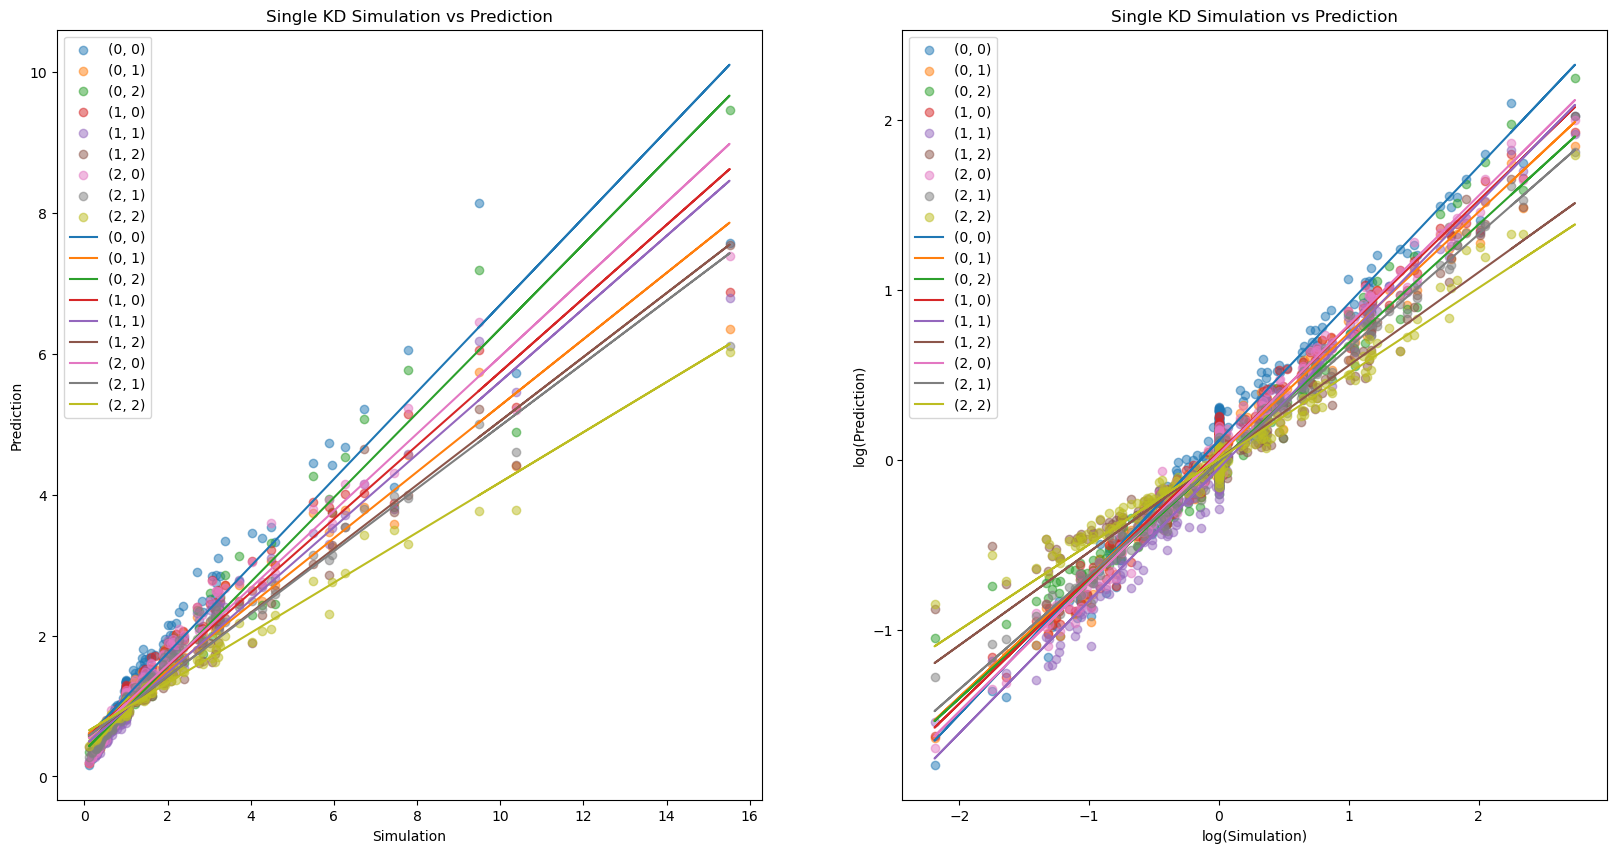

In [21]:
#per key plot single_kd_pred_per_prot_mean at key vs singlew_kd_sim
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
for key in single_kd_pred_per_prot_mean.keys():
    ax1.scatter(single_kd_sim, single_kd_pred_per_prot_mean[key], label=key, alpha=0.5)
ax1.set_title('Single KD Simulation vs Prediction')
ax1.set_xlabel('Simulation')
ax1.set_ylabel('Prediction')
# log scale
#ax1.set_xscale('log')
#ax1.set_yscale('log')
# per ey fit linear line
print('Linear Fit:')
for key in single_kd_pred_per_prot_mean.keys():
    ax1.plot(single_kd_sim, np.poly1d(np.polyfit(single_kd_sim, single_kd_pred_per_prot_mean[key], 1))(single_kd_sim), label=key)
    # print equation of line
    print(f'{key}: y = {np.poly1d(np.polyfit(single_kd_sim, single_kd_pred_per_prot_mean[key], 1))[1]:.2f}x + {np.poly1d(np.polyfit(single_kd_sim, single_kd_pred_per_prot_mean[key], 1))[0]:.2f}')
ax1.legend()

# log scale
for key in single_kd_pred_per_prot_mean.keys():
    ax2.scatter(np.log(single_kd_sim), np.log(single_kd_pred_per_prot_mean[key]), label=key, alpha=0.5)
ax2.set_title('Single KD Simulation vs Prediction')
ax2.set_xlabel('log(Simulation)')
ax2.set_ylabel('log(Prediction)')
print('Log Fit:')
# per ey fit linear line
for key in single_kd_pred_per_prot_mean.keys():
    ax2.plot(np.log(single_kd_sim), np.poly1d(np.polyfit(np.log(single_kd_sim), np.log(single_kd_pred_per_prot_mean[key]), 1))(np.log(single_kd_sim)), label=key)
    # print equation of line
    print(f'{key}: y = {np.poly1d(np.polyfit(np.log(single_kd_sim), np.log(single_kd_pred_per_prot_mean[key]), 1))[1]:.2f}x + {np.poly1d(np.polyfit(np.log(single_kd_sim), np.log(single_kd_pred_per_prot_mean[key]), 1))[0]:.2f}')
ax2.legend()

# Pairwise Probabilities

In [22]:
#load pairwise kd values
pair_kd_sim = np.loadtxt(simulation_path+'/secondFromProt1/prot1/pairwise_kds.txt')

In [24]:
#predict pairwise probabilities
pair_prob_pred = MIMENetEnsemble.inferPairwiseProbabilities(model, input_size, 100)

 43%|████▎     | 43/100 [24:41<32:43, 34.45s/it] 


KeyboardInterrupt: 

In [ ]:
pair_prob_pred = np.array(pair_prob_pred)
pair_prob_pred_means = np.mean(pair_prob_pred, axis=1)
pair_prob_pred_conf = np.zeros((pair_prob_pred_means.shape[0], 2))
for i in range(pair_prob_pred_means.shape[0]):
    pair_prob_pred_conf[i] = np.quantile(pair_prob_pred[i], [0.025, 0.975])

print(pair_prob_pred_means[0:10])
print(pair_prob_pred_conf[0:10])

[0.32754535 0.55177114 0.65020043 0.32842544 0.5395796  0.63402449
 0.37046779 0.58482877 0.66293151 0.38887472]
[[0.29137795 0.36943372]
 [0.52327129 0.58901789]
 [0.61336124 0.68463254]
 [0.29645075 0.36253735]
 [0.5102965  0.568915  ]
 [0.59637517 0.66134683]
 [0.32882589 0.40701017]
 [0.55442984 0.61418302]
 [0.63236235 0.69423126]
 [0.36153558 0.42801232]]


Text(0.8, 0.1, 'r = 0.96')

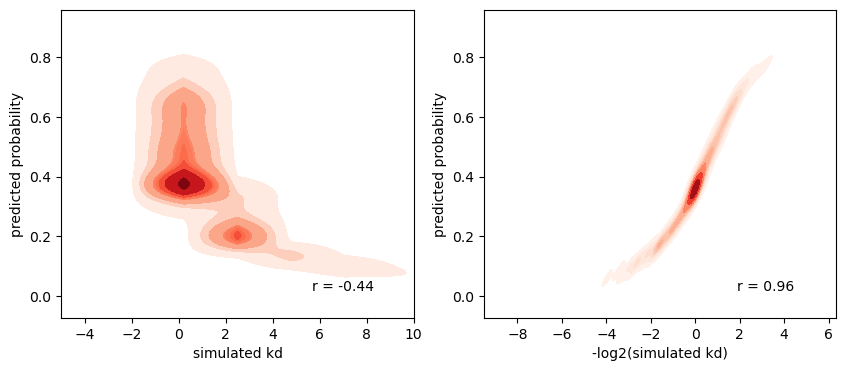

In [ ]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_kd_sim vs pair_kd_pred as kde plot
sns.kdeplot(x=pair_kd_sim, y=pair_prob_pred_means, cmap='Reds', fill=True, ax=ax1)
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted probability')
#set x limit
ax1.set_xlim(-5, 10)
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_kd_sim, pair_prob_pred_means)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_kd_sim) vs log2(pair_kd_pred) as kde plot
sns.kdeplot(x=-np.log2(pair_kd_sim), y=pair_prob_pred_means, cmap='Reds', fill=True, ax=ax2)
ax2.set_xlabel('-log2(simulated kd)')
ax2.set_ylabel('predicted probability')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(-np.log2(pair_kd_sim), pair_prob_pred_means)[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)

Text(0.8, 0.1, 'r = 0.96')

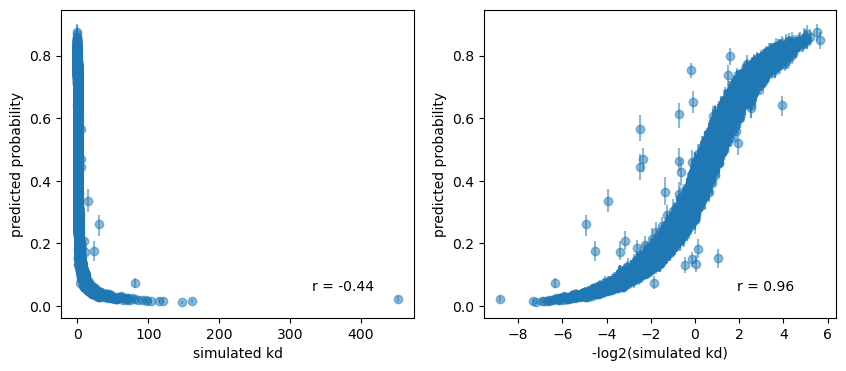

In [ ]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_kd_sim vs pair_kd_pred as kde plot
ax1.scatter(x=pair_kd_sim, y=pair_prob_pred_means, alpha=0.5)
ax1.vlines(x=pair_kd_sim, ymin=pair_prob_pred_conf[:,0], ymax=pair_prob_pred_conf[:,1], alpha=0.5)
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted probability')
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_kd_sim, pair_prob_pred_means)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_kd_sim) vs log2(pair_kd_pred) as kde plot
ax2.scatter(x=-np.log2(pair_kd_sim), y=pair_prob_pred_means, alpha=0.5)
ax2.vlines(x=-np.log2(pair_kd_sim), ymin=pair_prob_pred_conf[:,0], ymax=pair_prob_pred_conf[:,1], alpha=0.5)
ax2.set_xlabel('-log2(simulated kd)')
ax2.set_ylabel('predicted probability')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(-np.log2(pair_kd_sim), pair_prob_pred_means)[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)

# Pairwise Kds

In [25]:
#predict pairwise kds
pair_kd_pred = MIMENetEnsemble.inferPairwiseKds(model, input_size, 100)

  0%|          | 0/100 [01:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# save pair_kd_pred
np.savetxt('./pair_kd_pred.txt', pair_kd_pred)

In [26]:
# load pair_kd_pred
pair_kd_pred = np.loadtxt('./pair_kd_pred.txt')

In [27]:
pair_kd_pred = np.array(pair_kd_pred)
pair_kd_pred_means = np.mean(pair_kd_pred, axis=1)
pair_kd_pred_conf = np.zeros((pair_kd_pred_means.shape[0], 2))
for i in range(pair_kd_pred_means.shape[0]):
    pair_kd_pred_conf[i] = np.quantile(pair_kd_pred[i], [0.025, 0.975])

print(pair_kd_pred_means[0:10])
print(pair_kd_pred_conf[0:10])

[1.08314186 0.42899279 0.29390373 1.06197046 0.44529451 0.30514602
 0.9148624  0.37768329 0.26577575 0.91981473]
[[0.85073183 1.35872679]
 [0.3447471  0.52159408]
 [0.22339121 0.35495326]
 [0.81472866 1.32164449]
 [0.35502978 0.55208049]
 [0.25313119 0.36906209]
 [0.66150301 1.18170316]
 [0.29398518 0.47203974]
 [0.21041773 0.3456495 ]
 [0.74085982 1.11468899]]


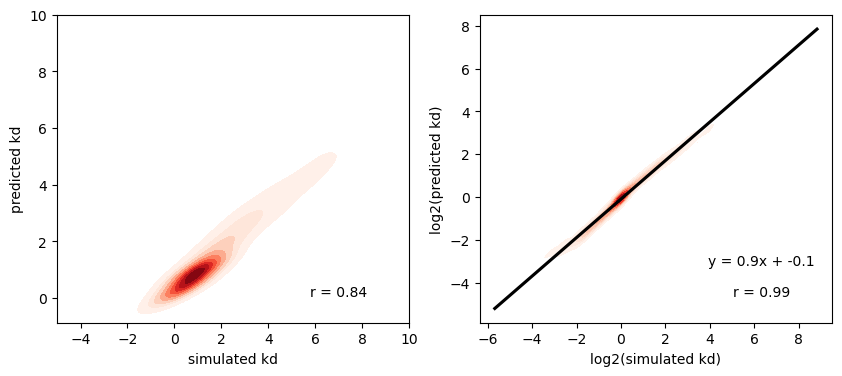

In [28]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_kd_sim vs pair_kd_pred_means as kde plot
sns.kdeplot(x=pair_kd_sim, y=pair_kd_pred_means, cmap='Reds', fill=True, ax=ax1, clip=(-5, 10))
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted kd')
#set x limit
ax1.set_xlim(-5, 10)
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_kd_sim, pair_kd_pred_means)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_kd_sim) vs log2(pair_kd_pred_means) as kde plot
sns.kdeplot(x=np.log2(pair_kd_sim), y=np.log2(pair_kd_pred_means), cmap='Reds', fill=True, ax=ax2)
ax2.set_xlabel('log2(simulated kd)')
ax2.set_ylabel('log2(predicted kd)')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(np.log2(pair_kd_sim), np.log2(pair_kd_pred_means))[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)
#show line of best fit
sns.regplot(x=np.log2(pair_kd_sim), y=np.log2(pair_kd_pred_means), color='black', scatter=False, ax=ax2)
# show equation of line of best fit
plt.text(0.8, 0.2, 'y = '+str(np.round(np.polyfit(np.log2(pair_kd_sim), np.log2(pair_kd_pred_means), 1)[0], 2))+'x + '+str(np.round(np.polyfit(np.log2(pair_kd_sim), np.log2(pair_kd_pred_means), 1)[1], 2)), ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

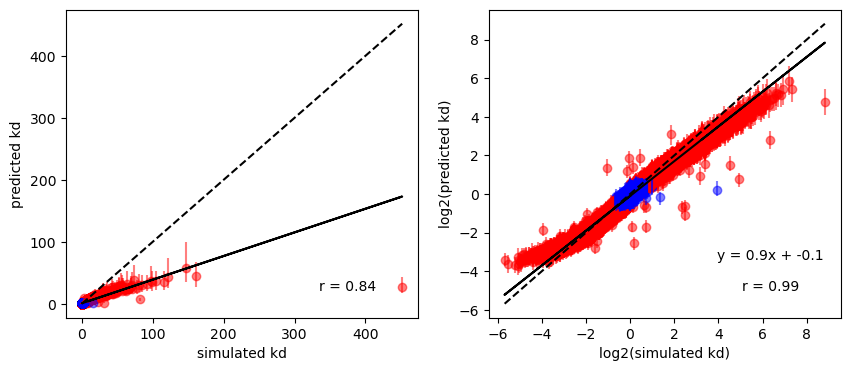

In [29]:
# get indices where interval does not contain 1
pair_kd_pred_conf_sig = np.where((pair_kd_pred_conf[:,0] > 1) | (pair_kd_pred_conf[:,1] < 1))
pair_kd_pred_conf_not_sig = np.where((pair_kd_pred_conf[:,0] < 1) & (pair_kd_pred_conf[:,1] > 1))
pair_kd_pred_means_sig = pair_kd_pred_means[pair_kd_pred_conf_sig]
pair_kd_pred_means_not_sig = pair_kd_pred_means[pair_kd_pred_conf_not_sig]

# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_kd_sim vs pair_kd_pred_means as scatter plot
ax1.scatter(x=pair_kd_sim[pair_kd_pred_conf_sig], y=pair_kd_pred_means_sig, alpha=0.5, color='red')
ax1.vlines(x=pair_kd_sim[pair_kd_pred_conf_sig], ymin=pair_kd_pred_conf[pair_kd_pred_conf_sig,0], ymax=pair_kd_pred_conf[pair_kd_pred_conf_sig,1], alpha=0.5, color='red')
ax1.scatter(x=pair_kd_sim[pair_kd_pred_conf_not_sig], y=pair_kd_pred_means_not_sig, alpha=0.5, color='blue')
ax1.vlines(x=pair_kd_sim[pair_kd_pred_conf_not_sig], ymin=pair_kd_pred_conf[pair_kd_pred_conf_not_sig,0], ymax=pair_kd_pred_conf[pair_kd_pred_conf_not_sig,1], alpha=0.5, color='blue')
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted kd')
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_kd_sim, pair_kd_pred_means)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
# plot line of best fit
ax1.plot(pair_kd_sim, np.poly1d(np.polyfit(pair_kd_sim, pair_kd_pred_means, 1))(pair_kd_sim), color='black')
#show equation of line of best fit
ax1.text(0.8, 0.2, 'y = '+str(np.round(np.polyfit(pair_kd_sim, pair_kd_pred_means, 1)[0], 2))+'x + '+str(np.round(np.polyfit(pair_kd_sim, pair_kd_pred_means, 1)[1], 2)), ha='center', va='center', transform=plt.gca().transAxes)
# plot 1:1 line as dashed line
ax1.plot([min(pair_kd_sim), max(pair_kd_sim)], [min(pair_kd_sim), max(pair_kd_sim)], color='black', linestyle='dashed')
#plot log2(pair_kd_sim) vs log2(pair_kd_pred_means) as scatter plot
ax2.scatter(x=np.log2(pair_kd_sim[pair_kd_pred_conf_sig]), y=np.log2(pair_kd_pred_means_sig), alpha=0.5, color='red')
ax2.vlines(x=np.log2(pair_kd_sim[pair_kd_pred_conf_sig]), ymin=np.log2(pair_kd_pred_conf[pair_kd_pred_conf_sig,0]), ymax=np.log2(pair_kd_pred_conf[pair_kd_pred_conf_sig,1]), alpha=0.5, color='red')
ax2.scatter(x=np.log2(pair_kd_sim[pair_kd_pred_conf_not_sig]), y=np.log2(pair_kd_pred_means_not_sig), alpha=0.5, color='blue')
ax2.vlines(x=np.log2(pair_kd_sim[pair_kd_pred_conf_not_sig]), ymin=np.log2(pair_kd_pred_conf[pair_kd_pred_conf_not_sig,0]), ymax=np.log2(pair_kd_pred_conf[pair_kd_pred_conf_not_sig,1]), alpha=0.5, color='blue')
ax2.set_xlabel('log2(simulated kd)')
ax2.set_ylabel('log2(predicted kd)')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(np.log2(pair_kd_sim), np.log2(pair_kd_pred_means))[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)
#show line of best fit
ax2.plot(np.log2(pair_kd_sim), np.poly1d(np.polyfit(np.log2(pair_kd_sim), np.log2(pair_kd_pred_means), 1))(np.log2(pair_kd_sim)), color='black')
#show equation of line of best fit
ax2.text(0.8, 0.2, 'y = '+str(np.round(np.polyfit(np.log2(pair_kd_sim), np.log2(pair_kd_pred_means), 1)[0], 2))+'x + '+str(np.round(np.polyfit(np.log2(pair_kd_sim), np.log2(pair_kd_pred_means), 1)[1], 2)), ha='center', va='center', transform=plt.gca().transAxes)
#show 1:1 line as dashed line
ax2.plot([min(np.log2(pair_kd_sim)), max(np.log2(pair_kd_sim))], [min(np.log2(pair_kd_sim)), max(np.log2(pair_kd_sim))], color='black', linestyle='dashed')

In [30]:
# construct confusion matrix for kd values

kd_tp = 0
kd_fp = 0
kd_fn = 0
kd_tn = 0

# iterate through all values
for i in range(len(pair_kd_sim)):
    interval = pair_kd_pred_conf[i]
    # if interval does not contain 1 > positive
    if interval[0] > 1 or interval[1] < 1:
        # if simulation is 1 > negative
        if pair_kd_sim[i] == 1:
            kd_fp += 1
        # if simulation is not 1 > positive
        else:
            kd_tp += 1
    # if interval contains 1 > negative
    else:
        # if simulation is 1 > positive
        if pair_kd_sim[i] == 1:
            kd_tn += 1
        # if simulation is not 1 > negative
        else:
            kd_fn += 1

# print confusion matrix
print('Confusion Matrix - Kd values:'+ '\n')
print(f'{"":>10}{"Simulation+":>10}{"Simulation-"}')
print(f'{"Prediction+":>10}{kd_tp:>10}{kd_fp:>10}')
print(f'{"Prediction-":>10}{kd_fn:>10}{kd_tn:>10}')

# print accuracy
print(f'Accuracy: {(kd_tp + kd_tn) / (kd_tp + kd_fp + kd_fn + kd_tn):.2f}')

Confusion Matrix - Kd values:

          Simulation+Simulation-
Prediction+     28293       476
Prediction-      4555     11226
Accuracy: 0.89


In [31]:
# load simulated epistasis
epi_sim = np.loadtxt(simulation_path+'/secondFromProt1/prot1/pairwise_epistasis.txt')

In [80]:
# get indices where epistasis is not 1
epi_sim_not_1 = np.where(epi_sim != 1)[0]
len(epi_sim_not_1)

47

Text(0.8, 0.1, 'r = 0.99')

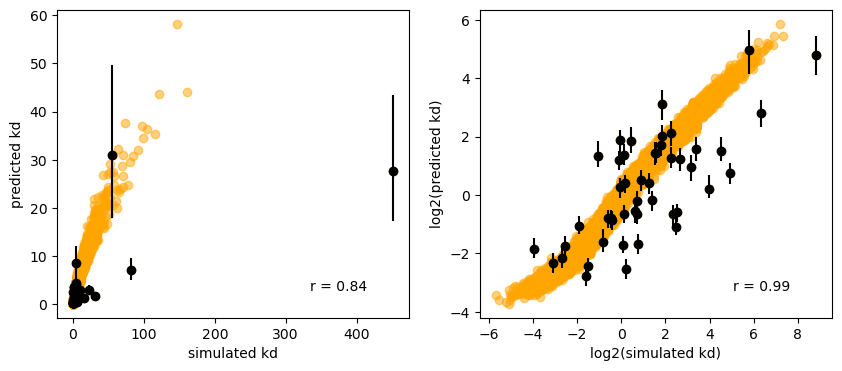

In [33]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

#plot pair_kd_sim vs pair_kd_pred_means as scatter plot
ax1.scatter(x=pair_kd_sim, y=pair_kd_pred_means, alpha=0.5, color='orange')
#ax1.vlines(x=pair_kd_sim, ymin=pair_kd_pred_conf[:,0], ymax=pair_kd_pred_conf[:,1], alpha=0.5, color='orange')
ax1.scatter(x=pair_kd_sim[epi_sim_not_1], y=pair_kd_pred_means[epi_sim_not_1], color='black')
ax1.vlines(x=pair_kd_sim[epi_sim_not_1], ymin=pair_kd_pred_conf[epi_sim_not_1,0], ymax=pair_kd_pred_conf[epi_sim_not_1,1], color='black')
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted kd')
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_kd_sim, pair_kd_pred_means)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_kd_sim) vs log2(pair_kd_pred_means) as scatter plot
ax2.scatter(x=np.log2(pair_kd_sim), y=np.log2(pair_kd_pred_means), alpha=0.5, color='orange')
#ax2.vlines(x=np.log2(pair_kd_sim), ymin=np.log2(pair_kd_pred_conf[:,0]), ymax=np.log2(pair_kd_pred_conf[:,1]), alpha=0.5, color='orange')
ax2.scatter(x=np.log2(pair_kd_sim[epi_sim_not_1]), y=np.log2(pair_kd_pred_means[epi_sim_not_1]), color='black')
ax2.vlines(x=np.log2(pair_kd_sim[epi_sim_not_1]), ymin=np.log2(pair_kd_pred_conf[epi_sim_not_1,0]), ymax=np.log2(pair_kd_pred_conf[epi_sim_not_1,1]), color='black')
ax2.set_xlabel('log2(simulated kd)')
ax2.set_ylabel('log2(predicted kd)')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(np.log2(pair_kd_sim), np.log2(pair_kd_pred_means))[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)

In [115]:
def inferEpistasis(singleKds : list, pairwiseKds : list):
    
    single_kd_pred = np.array(singleKds)
    single_kd_pred_means = np.mean(single_kd_pred, axis=1)
    single_kd_pred_conf = np.zeros((single_kd_pred_means.shape[0], 2))
    for i in range(single_kd_pred_means.shape[0]):
        single_kd_pred_conf[i] = np.quantile(single_kd_pred[i], [0.025, 0.975])

    pairwise_kd_pred = np.array(pairwiseKds)
    pairwise_kd_pred_means = np.mean(pairwise_kd_pred, axis=1)
    pairwise_kd_pred_conf = np.zeros((pairwise_kd_pred_means.shape[0], 2))
    for i in range(pairwise_kd_pred_means.shape[0]):
        pairwise_kd_pred_conf[i] = np.quantile(pairwise_kd_pred[i], [0.025, 0.975])

    #iterate through all possible pairs
    epistasis = []
    j = 0
    count_pair_sign = 0
    count_pair_not_sign = 0
    for pos1 in range(0,single_kd_pred.shape[0], 3):
        for pos2 in range(pos1+3, single_kd_pred.shape[0], 3):
            for mut1 in range(3):
                for mut2 in range(3):
            
                    # check if the lower bounds of the intervals are both above 1
                    single_kds_above_1 = single_kd_pred_conf[pos1+mut1][0] > 1 and single_kd_pred_conf[pos2+mut2][0] > 1

                    # check if the upper bounds of the intervals are both below 1
                    single_kds_below_1 = single_kd_pred_conf[pos1+mut1][1] < 1 and single_kd_pred_conf[pos2+mut2][1] < 1

                    # check if pairwise interval contains 1
                    pairwise_kd_contains_1 = pairwise_kd_pred_conf[j][0] < 1 and pairwise_kd_pred_conf[j][1] > 1
                    count_pair_not_sign += 1
                    # check if the lower bound of the pairwise interval is above 1
                    pairwise_kd_above_1 = pairwise_kd_pred_conf[j][0] > 1
                    count_pair_sign += 1
                    # check if the upper bound of the pairwise interval is below 1
                    pairwise_kd_below_1 = pairwise_kd_pred_conf[j][1] < 1
                    count_pair_sign += 1

                    if (single_kds_above_1 and pairwise_kd_contains_1) or (single_kds_below_1 and pairwise_kd_contains_1) or (single_kds_above_1 and pairwise_kd_below_1) or (single_kds_below_1 and pairwise_kd_above_1):
                        epistasis.append(1)
                    else:
                        epistasis.append(0)
                    
                    j += 1

    print('count_pair_sign: ', count_pair_sign)
    print('count_pair_not_sign: ', count_pair_not_sign)

    return epistasis

In [116]:
# infer epistasis
epi_pred = inferEpistasis(single_kd_pred, pair_kd_pred)

count_pair_sign:  89100
count_pair_not_sign:  44550


In [114]:
print(len(epi_pred), len(epi_sim))

44550 44550


In [99]:
# construct confusion matrix

epi_tp = 0
epi_fp = 0
epi_tn = 0
epi_fn = 0

for i in range(len(epi_pred)):
    if epi_pred[i] == 1 and epi_sim[i] != 1:
        epi_tp += 1
    elif epi_pred[i] == 1 and epi_sim[i] == 1:
        epi_fp += 1
    elif epi_pred[i] == 0 and epi_sim[i] == 1:
        epi_tn += 1
    elif epi_pred[i] == 0 and epi_sim[i] != 1:
        epi_fn += 1

# print confusion matrix
print('Confusion Matrix - Kd values:'+ '\n')
print(f'{"":>10}{"Simulation+":>10}{"Simulation-"}')
print(f'{"Prediction+":>10}{epi_tp:>10}{epi_fp:>10}')
print(f'{"Prediction-":>10}{epi_fn:>10}{epi_tn:>10}')

# print accuracy
print(f'Accuracy: {(epi_tp + epi_tn) / (epi_tp + epi_fp + epi_fn + epi_tn):.2f}')
# print sensitivity
print(f'Sensitivity: {epi_tp / (epi_tp + epi_fn):.2f}')

Confusion Matrix - Kd values:

          Simulation+Simulation-
Prediction+         0         0
Prediction-        47     44503
Accuracy: 1.00
Sensitivity: 0.00
